Missing metrics (bars would be zero): ['IBLL']


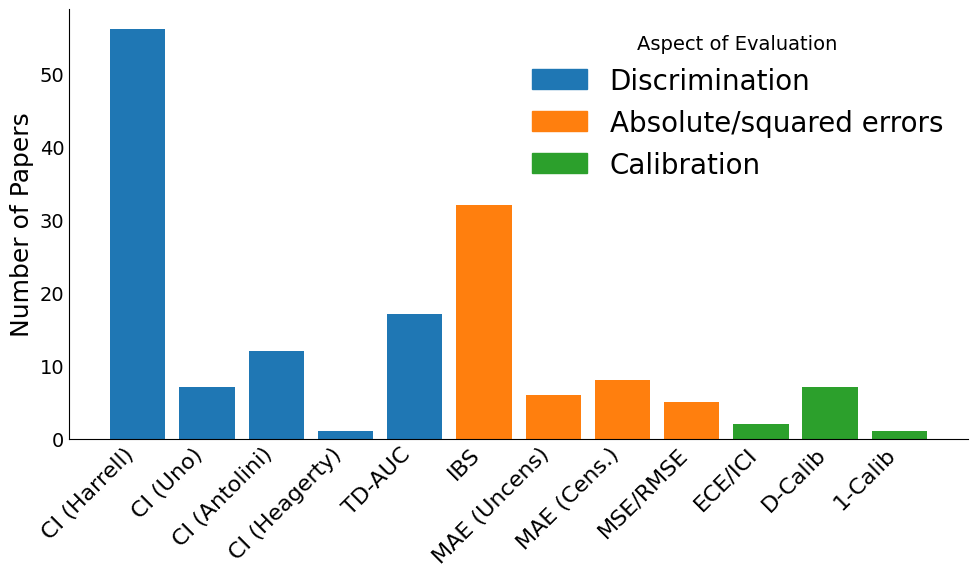

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

matplotlib_style = 'default'
plt.style.use(matplotlib_style)
plt.rcParams.update({
    'axes.labelsize': 'large',
    'axes.titlesize': 'large',
    'xtick.labelsize': 'large',
    'font.size': 14.0,
    'legend.fontsize': 'large'
})

# Load data
df = pd.read_csv('data/metrics_used.csv')

# Count non-empty values per metric (excluding the title column)
metric_counts = df.iloc[:, 1:].apply(lambda col: col.notna() & (col != ''), axis=0).sum()

# Create the new combined metric 'MAE (Cens.)'
mae_cens_sum = metric_counts.get("MAE (Hinge)", 0) + metric_counts.get("MAE (Margin)", 0) + metric_counts.get("MAE (PO)", 0)

# Remove the three original MAE metrics
metric_counts = metric_counts.drop(["MAE (Hinge)", "MAE (Margin)", "MAE (PO)"], errors='ignore')

# Add the combined metric
metric_counts["MAE (Cens.)"] = mae_cens_sum

# Define categories with the new combined metric instead of the three separate ones
categories = {
    "Discrimination": [
        "CI (Harrell)",
        "CI (Uno)",
        "CI (Antolini)",
        "CI (Heagerty)",
        "TD-AUC"
    ],
    "Absolute/squared errors": [
        "IBS",
        "MAE (Uncens)",
        "MAE (Cens.)",
        "MSE/RMSE"
    ],
    "Calibration": [
        "IBLL",
        "ECE/ICI",
        "D-Calib",
        "1-Calib"
    ]
}

# Define category colors
category_colors = {
    "Discrimination": "tab:blue",
    "Absolute/squared errors": "tab:orange",
    "Calibration": "tab:green"
}

# Flatten to map each metric to its category and color
metric_to_category = {metric: cat for cat, metrics in categories.items() for metric in metrics}
metric_to_color = {metric: category_colors[metric_to_category[metric]] for metric in metric_counts.index if metric in metric_to_category}

# Sort metrics by category for grouped plotting
sorted_metrics = sum(categories.values(), [])

# Plot only valid metrics
existing_metrics = [m for m in sorted_metrics if m in metric_counts.index]
missing_metrics = [m for m in sorted_metrics if m not in metric_counts.index]

print("Missing metrics (bars would be zero):", missing_metrics)
sorted_metrics = existing_metrics

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    sorted_metrics,
    [metric_counts.get(m, 0) for m in sorted_metrics],
    color=[metric_to_color.get(m, "gray") for m in sorted_metrics]
)

# Remove plot borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend handles (category color blocks)
legend_handles = [Patch(color=color, label=cat) for cat, color in category_colors.items()]
plt.legend(handles=legend_handles, title="Aspect of Evaluation", frameon=False, fontsize=20)

# Labeling
plt.ylabel("Number of Papers", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.tick_params(axis='x', which='both', length=0)
plt.tick_params(axis='y', which='both', length=0)
plt.tight_layout()
plt.savefig("plots/metrics_used.pdf", format="pdf", bbox_inches="tight")
plt.show()

<Figure size 1000x700 with 0 Axes>

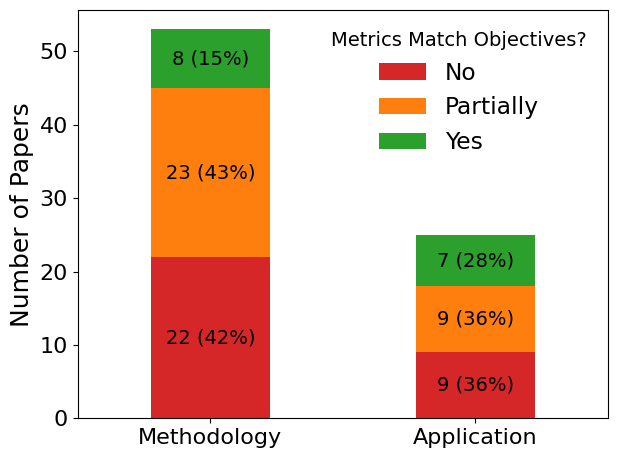

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the correct file
df = pd.read_csv("data/correct_evaluation.csv")

# Remove completely empty rows
df = df.dropna(how="all")

# Select and clean relevant columns
df_eval = df.loc[:, ["Problem type", "Metrics Match Objectives?"]].dropna()

# Normalize labels
df_eval.loc[:, "Metrics Match Objectives?"] = (
    df_eval["Metrics Match Objectives?"]
    .str.strip()
    .str.split(",", n=1).str[0]
    .str.capitalize()
)

df_eval.loc[:, "Problem type"] = df_eval["Problem type"].str.strip()

# Count combinations
counts = (
    df_eval.groupby(["Problem type", "Metrics Match Objectives?"])
    .size()
    .unstack(fill_value=0)
)

# Ensure ordering
counts = counts.reindex(["Methodology", "Application"])

# Compute percentages
pct = counts.div(counts.sum(axis=1), axis=0) * 100

# ---- PLOT ----
plt.figure(figsize=(10,7))
ax = counts.plot(
    kind="bar",
    stacked=True,
    color={"Yes": "tab:green", "No": "tab:red", "Partially": "tab:orange"},
    fontsize=16
)
ax.legend(title="Metrics Match Objectives?", frameon=False)

# ---- SHRINK BAR WIDTHS MANUALLY (TRUE FIX) ----
desired_width = 0.45  # make bars narrow
for bar in ax.patches:
    current_width = bar.get_width()
    diff = current_width - desired_width

    # Shrink bar & shift it so it's still centered:
    bar.set_width(desired_width)
    bar.set_x(bar.get_x() + diff / 2)

# Labels
plt.ylabel("Number of Papers", fontsize=18)
plt.xlabel("", fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(fontsize=16)

# ---- ADD BOLD LABELS (count + %) ----
for i, (ptype, row) in enumerate(counts.iterrows()):
    cumulative = 0
    for outcome in ["No", "Partially", "Yes"]:
        value = row.get(outcome, 0)
        percent = pct.loc[ptype, outcome]
        if value > 0:
            label = f"{value} ({percent:.0f}%)"
            ax.text(
                i,
                cumulative + value/2,
                label,
                ha="center",
                va="center",
                fontsize=14,
                color="black"
            )
        cumulative += value

plt.tight_layout()
plt.savefig("plots/metrics_correctness.pdf", format="pdf", bbox_inches="tight")
plt.show()
